# Error analysis and (better) testing

We train a text classification model on financial news (mostly as a black-box, focus is not on modelling), and then use the model to understand some best practices in error analysis and testing.

You are encouraged to play around with the code and modify / re-built parts of it as you fit: there is NO substitute for "tinkering with code" to understand how all the concepts fit together (corollary: all this code is written for pedagogical purposes, so some functions are re-used from previous lectures to provide a self-sufficient script).

_First, let's make sure we are running from the virtual env_

In [1]:
import sys
sys.executable

'/Users/jacopotagliabue/opt/anaconda3/envs/free/bin/python'

In [2]:
# some global import
# we import specific libraries in due time
import json
import glob
import os
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from random import choice

In [3]:
%matplotlib inline

## Data loading

In [4]:
# make sure you have the datasets library installed
# see: https://github.com/huggingface/datasets

# !pip install datasets

In [5]:
import string

# some utils function
def get_finance_sentiment_dataset(split: str='sentences_allagree'):
    # load financial dataset from HF
    from datasets import load_dataset
    # https://huggingface.co/datasets/financial_phrasebank
    # by default, load just sentences for which all annotators agree
    dataset = load_dataset("financial_phrasebank", split)
    
    return dataset['train']


def get_finance_sentences():
    dataset = get_finance_sentiment_dataset()
    cleaned_dataset = [[pre_process_sentence(_['sentence']), _['label']] for _ in dataset]
    # debug 
    print("{} cleaned sentences from finance dataset\n".format(len(cleaned_dataset)))
    
    return cleaned_dataset


def pre_process_sentence(sentence: str):
    # this choices are VERY important. Here, we take a simplified 
    # view, remove the punctuations and just lower case everything
    lower_sentence = sentence.lower()
    # remove punctuation
    # nice suggestion from https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    # if we change the exclude set, we can control what to exclude
    exclude = set(string.punctuation)
    return ''.join(ch for ch in lower_sentence if ch not in exclude)

In [6]:
finance_dataset = get_finance_sentences()
# print out the first item in the dataset, to check the format
finance_dataset[0]

Found cached dataset financial_phrasebank (/Users/jacopotagliabue/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

2264 cleaned sentences from finance dataset



['according to gran  the company has no plans to move all production to russia  although that is where the company is growing ',
 1]

## Model training

Training a simple tf-idf classifier on text and return the model for analysis, prediction. More info about the model:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Some more details on NLP classification can be found for example in our 2021 course: https://github.com/jacopotagliabue/FREE_7773


In [7]:
# first get the final dataset splits etc.
from sklearn.model_selection import train_test_split

finance_dataset_text = [_[0] for _ in finance_dataset]
finance_dataset_label = [_[1] for _ in finance_dataset]
all_labels = set(finance_dataset_label)
print("All labels are: {}".format(all_labels))
X_train, X_test, y_train, y_test = train_test_split(finance_dataset_text, 
                                                    finance_dataset_label, 
                                                    test_size=0.1, 
                                                    random_state=42)
print("Total train examples {}, test {}".format(len(X_train), len(y_train)))
# debug with examples
print(X_train[:2], y_train[:2])

All labels are: {0, 1, 2}
Total train examples 2037, test 2037
['the train is expected to cross the russian territory in 9 days  reaching the vostochny port ', 'the policy was also aimed at making the companies more profitable and competitive '] [1, 2]


In [8]:
def train_model(tf_idf_x_train, y_train):
    """
    Train a simple classifier over the text vectors.
    Model from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    """
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB()
    model.fit(tf_idf_x_train, y_train)
    
    return model

def get_trained_classifier(X_train, y_train):
    """
    Encapsulate the training here, as we really don't care about training details:
    the model is just useful to discuss testing strategies!
    """
    
    # map text to numerical vectors using TF-IDF and some sensible defaults
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
    tfidf_train = vectorizer.fit_transform(X_train)
    # debug: what does this shape mean?
    print(tfidf_train.shape)
    # train the model
    model = train_model(tfidf_train, y_train)
        
    # since we are treating of all this 
    return vectorizer, model

In [9]:
tf_vectorizer, clf_model = get_trained_classifier(X_train, y_train)

(2037, 6065)


## Evaluate the model

How well are we doing?

First, we now instantiate a classifier, train it and then predicting unseen test cases as usual.

In [10]:
X_test_transformed = tf_vectorizer.transform(X_test)
predicted = clf_model.predict(X_test_transformed)
predicted_prob = clf_model.predict_proba(X_test_transformed)
# debug output
print(predicted[:2], predicted_prob[:2])

[1 1] [[0.04644567 0.81626586 0.13728847]
 [0.11744389 0.71779367 0.16476244]]


We start by using standard quantitative metrics to evaluate our model

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_confusion_matrix_and_report(y_predicted, y_golden, with_plot=True):
    # calculate confusion matrix: 
    cm = confusion_matrix(y_golden, y_predicted)
    # build a readable report;
    # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report
    print('\nClassification Report')
    print(classification_report(y_golden, y_predicted))
    # plot the matrix
    if with_plot:
        plot_confusion_matrix(cm)
                                          
    return
                                          
def plot_confusion_matrix(c_matrix):
    plt.imshow(c_matrix, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.show()
    
    return

Total of # 227 test cases

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.84      0.95      0.89       145
           2       0.61      0.71      0.65        52

    accuracy                           0.78       227
   macro avg       0.81      0.57      0.54       227
weighted avg       0.81      0.78      0.73       227



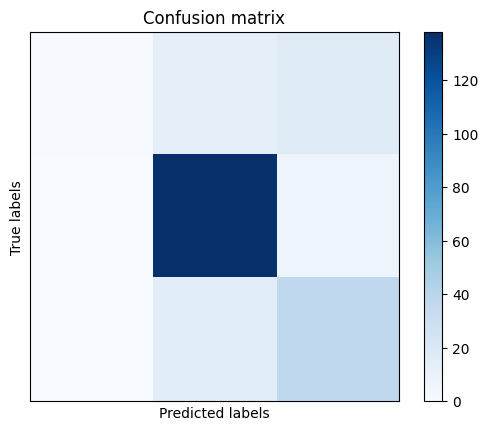

In [12]:
print("Total of # {} test cases".format(len(y_test)))
calculate_confusion_matrix_and_report(predicted, y_test)

### Error analysis

In [13]:
assert len(X_test) == len(predicted)
# manual inspection
mistakes = [(x, p, y, prob) for x, p, y, prob in zip(X_test, predicted, y_test, predicted_prob) if p != y]
print("Total of mistakes: {}".format(len(mistakes)))
# debug
print("Sentence: {}\nPredicted: {}, but it was: {}\nProbs: {}".format(*mistakes[0]))

Total of mistakes: 51
Sentence: the company slipped to an operating loss of eur 26 million from a profit of eur 13 million 
Predicted: 2, but it was: 0
Probs: [0.21494976 0.17169911 0.61335113]


In [14]:
for _ in range(3):
    rnd_mistake = choice(mistakes)
    print("Sentence: {}\nPredicted: {}, but it was: {}\nProbs: {}\n=======\n".format(*rnd_mistake))

Sentence: valmet automotive reports net sales of eur 85mn and operating profit of eur 8mn 
Predicted: 2, but it was: 1
Probs: [0.22385938 0.27542761 0.50071301]

Sentence:  small firms are suffering at the moment because they are likely to have money trouble   he added 
Predicted: 1, but it was: 0
Probs: [0.10433723 0.73461042 0.16105235]

Sentence: according to atria s president and ceo matti tikkakoski  the company s swedish operations significantly improved in the first quarter 
Predicted: 1, but it was: 2
Probs: [0.07643405 0.65946073 0.26410522]



In [15]:
# data slicing: instead of considering the performances on all dataset, 
# we split it according to categories important for our business

# for example, let's say we slice queries by quarter
slices = {
    "first quarter": [[], []],
    "second quarter": [[], []],
    "third quarter": [[], []],
    "fourth quarter": [[], []]
}

for x, p, y in zip(X_test, predicted, y_test):
    for _s in slices.keys():
        if _s in x:
            slices[_s][0].append(p)
            slices[_s][1].append(y)
            
# debug 
# print(slices["first quarter"])
            
for _slice, test_set in slices.items():
    if test_set[0]:
        print("Total of # {} cases in slice: {}".format(len(test_set[0]), _slice))
        calculate_confusion_matrix_and_report(test_set[0], test_set[1], with_plot=False)
        print("\n===========\n")

Total of # 3 cases in slice: first quarter

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      1.00      0.50         1
           2       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



Total of # 2 cases in slice: second quarter

Classification Report
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



Total of # 3 cases in slice: third quarter

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00 

/Users/jacopotagliabue/opt/anaconda3/envs/free/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We should be able to adapt the “black box testing” from traditional software systems to ML systems: it should be possible to evaluate the performance of a complex system by treating it as a black box, and only supply input-output pairs that are relevant for our qualitative understanding.

(see for example the excellent paper: https://arxiv.org/abs/2005.04118)

In [16]:
# Test for edge cases / interesting cases / regression errors

# CASE 1:
# I'm particularly interesting in some company, say
# https://en.wikipedia.org/wiki/Comptel
# and want to make sure we are doing well there!

companies_I_care_about = ['comptel']

for company in companies_I_care_about:
    print("\n======\nFocus on target company: {}\n".format(company))
    for x, p, y in zip(X_test, predicted, y_test):
        if company in x:
            print("For '{}' =>\ngolden {}, predicted {}\n".format(
                x,
                y, 
                p))


Focus on target company: comptel

For 'in 2009  comptel slipped to a net loss of eur2 1 m from a profit of eur6 6 m in the previous year ' =>
golden 0, predicted 2

For 'major order in india comptel corporation has received a significant longterm order for mediation and provisioning solutions being used by a leading operator in india ' =>
golden 2, predicted 1



In [17]:
# CASE 2:
# Assuming we have some specific sentences to monitor, let's check for that!
sentences_I_care_about = [
    'the company slipped to an operating loss of eur 26 million from a profit of eur 13 million',
    'revenue in the quarter fell 8 percent to  euro  24 billion compared to a year earlier'
]
labels_I_care_about = [0, 0]

for x, p in zip(X_test, predicted):
     if x.strip() in sentences_I_care_about:
        print("For '{}', I expect {}, it was {}\n".format(
            x,
            p, 
            labels_I_care_about[sentences_I_care_about.index(x.strip())]
        ))

For 'the company slipped to an operating loss of eur 26 million from a profit of eur 13 million ', I expect 2, it was 0

For 'revenue in the quarter fell 8 percent to  euro  24 billion compared to a year earlier ', I expect 2, it was 0



In test classification, we desire to have a system robust to alternative specifications of the input string, for example we expect that the model response to:

"revenue in the quarter fell 8 percent to  euro  24 billion compared to a year earlier"

AND

"revenue in the quarter diminished by 8 percent to  euro  24 billion compared to the previous year"

would be identical.

While a full-fledge treatment of this problem is out of scope, let's see how this intuition works with working code.

In [18]:
# test for perturbations
test_sentences = [
    'the company slipped to an operating loss of eur 26 million from a profit of eur 13 million',
    'revenue in the quarter fell 8 percent to  euro  24 billion compared to a year earlier'
]

perturbated_sentences = [
    'operating loss surged to eur 26 million from a profit of eur 13 million',
    'revenue in the quarter diminished by 8 percent to  euro  24 billion compared to the previous year'
]

test_predicted = clf_model.predict(tf_vectorizer.transform(test_sentences))
perturbated_predicted = clf_model.predict(tf_vectorizer.transform(perturbated_sentences))

for s, t, p in zip(test_sentences, test_predicted, perturbated_predicted):
    print("\nFor sentence '{}', prediction was: {}, under perturbation: {}".format(
        s, t, p
    ))


For sentence 'the company slipped to an operating loss of eur 26 million from a profit of eur 13 million', prediction was: 2, under perturbation: 2

For sentence 'revenue in the quarter fell 8 percent to  euro  24 billion compared to a year earlier', prediction was: 2, under perturbation: 2


Bonus: a quick and easy way to generate perturbation is called back-translation.

The idea is that you can use machine translation to go:

SOURCE -> TARGET -> NEW_SOURCE

where NEW_SOURCE is a semantically equivalent, but not identical version of source. For example:

'hi' -> Italian target: 'ciao' -> 'hello'

'hi' and 'hello' have the same meaning so, 'hello' may be considered a perturbation of the original text.

A quick and dirty example follows (not "real" code!)

In [19]:
# !pip install BackTranslation

In [20]:
from BackTranslation import BackTranslation
trans = BackTranslation(url=[
      'translate.google.com',
      'translate.google.co.kr',
    ])
for t in test_sentences:
    result = trans.translate(t, src='en', tmp = 'zh-cn')
    print("Original is: {}\nNew sentence is: {}\n\n".format(t, result.result_text))

Original is: the company slipped to an operating loss of eur 26 million from a profit of eur 13 million
New sentence is: The company slipped into 26 million euros from the profit of 13 million euros.


Original is: revenue in the quarter fell 8 percent to  euro  24 billion compared to a year earlier
New sentence is: The revenue of this quarter fell 8 % to 24 billion euros


